# Python Test: Instruction
Description:  
There are several dataset provided in the red tab
1. pricing_project_dataset: This dataset is an aggregate level of model level of Shopee SKU vs Competitor SKU that was identify as a similar product. Key columns are shopee_model_price and competitor_model_price. End goal of this project is to make Shopee price lower than competitor. (Price of those two columns are in local currency)
2. platform_number: this dataset provide total Shopee Platform order and GMV (USD)
3. exchange_rate: this dataset provide exchange rate in case that currency conversion is needed

# 0.0 Understanding the Data

## 0.1 Import Python Libraries & Loading Data Set 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_pricing         = pd.read_csv("pricing_project_dataset.csv")
df_platform_number = pd.read_csv("platform_number.csv")
df_exchange_rate   = pd.read_csv("exchange_rate.csv")

## 0.2 Data Preprocessing

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# convert platform order and platform_gmv_usd to float
df_platform_number['platform order'] = df_platform_number['platform order'].str.replace(',', '').astype(float)
df_platform_number['platform_gmv_usd'] = df_platform_number['platform_gmv_usd'].str.replace(',', '').astype(float)

## 0.3 Exploratory data analysis

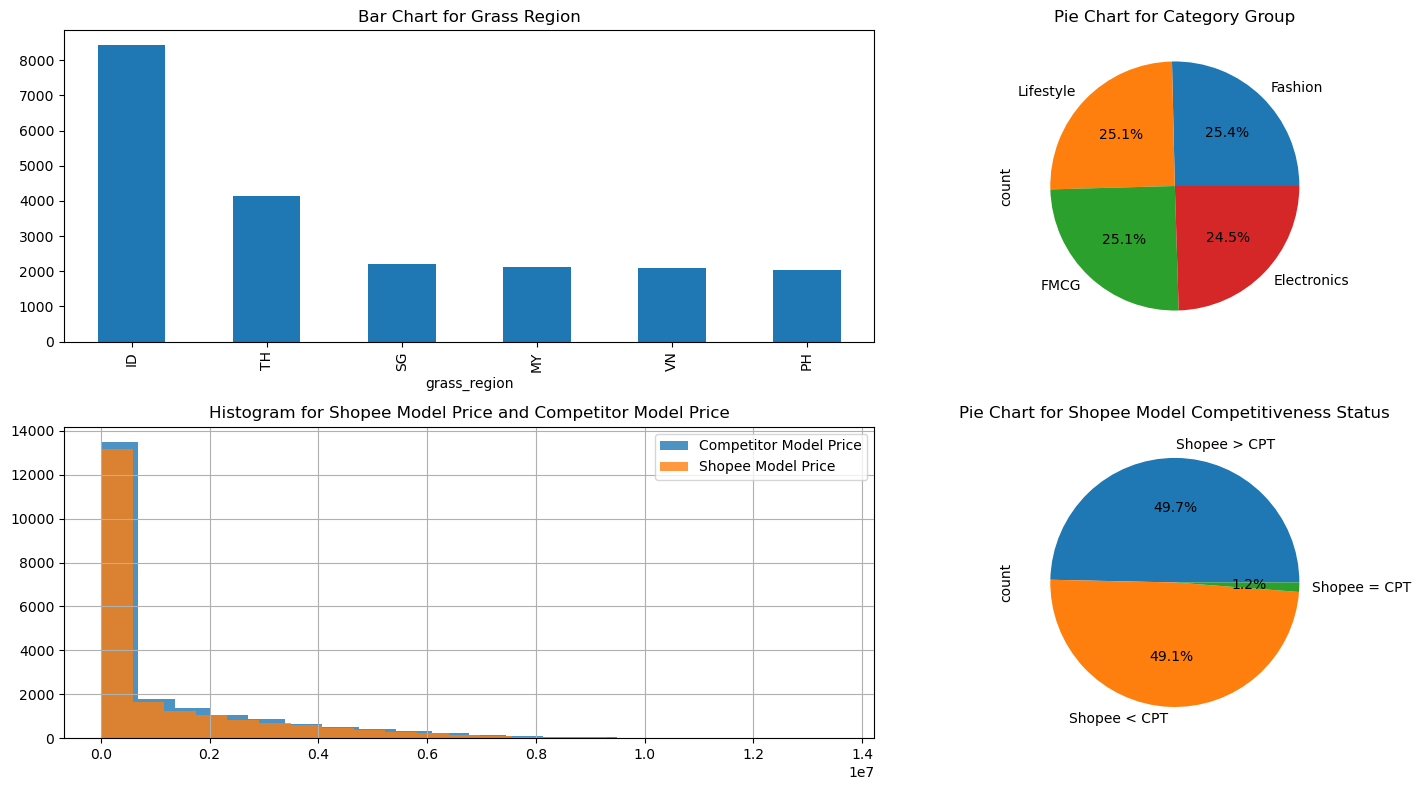

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Plot the bar chart for "grass_region"
axes[0, 0].set_title("Bar Chart for Grass Region")
df_pricing.value_counts("grass_region").plot(kind="bar", ax=axes[0, 0])

# Plot the pie chart for "category_group"
axes[0, 1].set_title("Pie Chart for Category Group")
df_pricing.value_counts("category_group").plot(kind="pie", autopct='%1.1f%%', ax=axes[0, 1])

# Plot the histogram for "shopee_model_price" and "competitor_model_price"
axes[1, 0].set_title("Histogram for Shopee Model Price and Competitor Model Price")
df_pricing["competitor_model_price"].hist(bins=20, alpha=0.8, label="Competitor Model Price", ax=axes[1, 0])
df_pricing["shopee_model_price"].hist(bins=20, alpha=0.8, label="Shopee Model Price", ax=axes[1, 0])
axes[1, 0].legend()

# Plot the pie chart for "shopee_model_competitiveness_status"
axes[1, 1].set_title("Pie Chart for Shopee Model Competitiveness Status")
df_pricing.value_counts("shopee_model_competitiveness_status").plot(kind="pie", autopct='%1.1f%%', ax=axes[1, 1])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

# Question 1: 
**Cluster item lv into each portion (dataset is at model lv) (5 points) from the dataset1 Please calculate and fill the data to this table**
- to calculate Order coverage, use column 'shopee_order' divided by Shopee platform order of those region in the dataset 'platform_number'
- to calculate net competitiveness metric, please see the formula below (please use net competitinveness by number of SKU)

## Q1.1 Order Coverage (by Item)

In [6]:
# solution 
df_grouped_region_sum_order = df_pricing.groupby(by=["grass_region"], as_index=False)["shopee_order"].sum()
df_platform_region_order = df_platform_number[["region", "platform order"]]
df_Order_Coverage = pd.merge(df_grouped_region_sum_order, df_platform_region_order, left_on="grass_region", right_on="region", how="left").drop(columns="grass_region")
df_Order_Coverage["order_coverage"] = df_Order_Coverage["shopee_order"]*100 / df_Order_Coverage["platform order"]
df_Order_Coverage

,shopee_order,region,platform order,order_coverage
0,848601,ID,1553364.13,54.63
1,207739,MY,333184.27,62.35
2,202688,PH,392687.73,51.62
3,219624,SG,526181.77,41.74
4,408024,TH,1018358.54,40.07
5,213484,VN,413006.15,51.69


## Q1.2 Net Competitiveness (by Item)

In [7]:
df_grouped_shopee_less_CPT = df_pricing.groupby(by=["grass_region"], as_index=False)["shopee_model_competitiveness_status"].apply(lambda x: (x=="Shopee < CPT").sum())
df_grouped_shopee_more_CPT = df_pricing.groupby(by=["grass_region"], as_index=False)["shopee_model_competitiveness_status"].apply(lambda x: (x=="Shopee > CPT").sum())
df_grouped_count_region = df_pricing.groupby(by=["grass_region"], as_index=False)["shopee_item_id"].count()

df_net_compet = df_grouped_shopee_less_CPT.merge(df_grouped_shopee_more_CPT, on="grass_region", how="left").merge(df_grouped_count_region, on="grass_region", how="left")
df_net_compet["net_compet"] = (df_net_compet["shopee_model_competitiveness_status_x"] - df_net_compet["shopee_model_competitiveness_status_y"]) / df_net_compet["shopee_item_id"]
df_net_compet.rename(columns={"shopee_model_competitiveness_status_x": "Shopee < CPT", "shopee_model_competitiveness_status_y": "Shopee > CPT", "shopee_item_id": "count"}, inplace=True)
df_net_compet

,grass_region,Shopee < CPT,Shopee > CPT,count,net_compet
0,ID,4222,4206,8428,0.00
1,MY,1029,1023,2118,0.00
2,PH,1011,1006,2025,0.00
3,SG,950,1085,2194,-0.06
4,TH,2069,2045,4137,0.01
5,VN,1035,1062,2097,-0.01


## Q1.3 # of Item

In [8]:
df_grouped_count_region = df_pricing.groupby(by=["grass_region"], as_index=False)["shopee_item_id"].count().rename(columns={"shopee_item_id": "count"})
df_grouped_count_region

,grass_region,count
0,ID,8428
1,MY,2118
2,PH,2025
3,SG,2194
4,TH,4137
5,VN,2097


## Q1 Solution

In [9]:
df_Order_Coverage, df_net_compet, df_grouped_count_region
df_q1_solution = pd.DataFrame()
df_q1_solution[["Region", "Order Coverage (by Item)"]] = df_Order_Coverage[["region", "order_coverage"]]
df_q1_solution[["Net Competitiveness (by Item)"]] = df_net_compet[["net_compet"]]
df_q1_solution[["# of Item"]] = df_grouped_count_region[["count"]]

df_q1_solution

,Region,Order Coverage (by Item),Net Competitiveness (by Item),# of Item
0,ID,54.63,0.00,8428
1,MY,62.35,0.00,2118
2,PH,51.62,0.00,2025
3,SG,41.74,-0.06,2194
4,TH,40.07,0.01,4137
5,VN,51.69,-0.01,2097


# Question 2:

**2. Please write a python or pyspark code to re-arrange the data set to item_lv with the given priority  (5 points)**  
P0: Shopee < CPT  
P1: Shopee = CPT  
P2: Shopee > CPT  
**note: if a model within same item falls into lowest P, then use lowest P to represent the item competitiveness status*

In [10]:
# since the ratio of shopee_item_id and shopee_model_id are same, we can use shopee_model_id to compare directly
df_pricing[["shopee_item_id", "shopee_model_id"]].groupby(by=["shopee_item_id"]).count().sort_values("shopee_model_id", ascending=False).head()

,shopee_model_id
shopee_item_id,
580861,1
6690036502,1
6689248828,1
6689084493,1
6688927784,1


In [11]:
# since the ratio of competitor_item_id and competitor_model_id are same, we can use competitor_model_id to compare directly
df_pricing[["competitor_item_id", "competitor_model_id"]].groupby(by=["competitor_item_id"]).count().sort_values("competitor_model_id", ascending=False).head()

,competitor_model_id
competitor_item_id,
728414,1
6667302452,1
6666396832,1
6666137677,1
6666000576,1


## Q2 Solution

In [12]:
df_q2_solution = df_pricing[["shopee_item_id", "shopee_model_id", "shopee_model_competitiveness_status"]]

df_q2_solution["priority"] = df_q2_solution["shopee_model_competitiveness_status"].apply(lambda x: "P0" if x=="Shopee < CPT" else ("P1" if x=="Shopee = CPT" else "P2"))
df_q2_solution.sort_values("priority", ascending=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_50876\667044493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2_solution["priority"] = df_q2_solution["shopee_model_competitiveness_status"].apply(lambda x: "P0" if x=="Shopee < CPT" else ("P1" if x=="Shopee = CPT" else "P2"))


,shopee_item_id,shopee_model_id,shopee_model_competitiveness_status,priority
10499,376413509,3784867317,Shopee < CPT,P0
11650,2865107126,9412966411,Shopee < CPT,P0
11652,3112647982,9340967368,Shopee < CPT,P0
11655,5973994675,4164936890,Shopee < CPT,P0
11658,9134585713,9694918274,Shopee < CPT,P0
...,...,...,...,...
3662,4181399028,3449901325,Shopee > CPT,P2
8726,7496093942,3515909495,Shopee > CPT,P2
13624,3845292035,6101776639,Shopee > CPT,P2
13616,1765323904,1004227637,Shopee > CPT,P2


# Question 3:

**3. How many item at top 30% of model that contribute in highest order to platform by each country/region? (5points)**

## Q3 Solution

In [13]:
df_q3_solution = df_pricing[df_pricing["shopee_order"]>df_pricing["shopee_order"].quantile(0.7)].groupby(by=["grass_region"], as_index=False)["shopee_order"].count()
df_q3_solution.rename(columns={"grass_region": "Region", "shopee_order": "# of items"}, inplace=True)
df_q3_solution

,Region,# of items
0,ID,2580
1,MY,600
2,PH,590
3,SG,653
4,TH,1180
5,VN,640


# Question 4: Dashboard 
https://docs.google.com/presentation/d/1I2BXh0EVO6i6r8fLYFiUFMNEtPpT8o-C5u3meIasP88/edit?usp=sharing

C:\Users\ASUS\AppData\Local\Temp\ipykernel_50876\4093309591.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


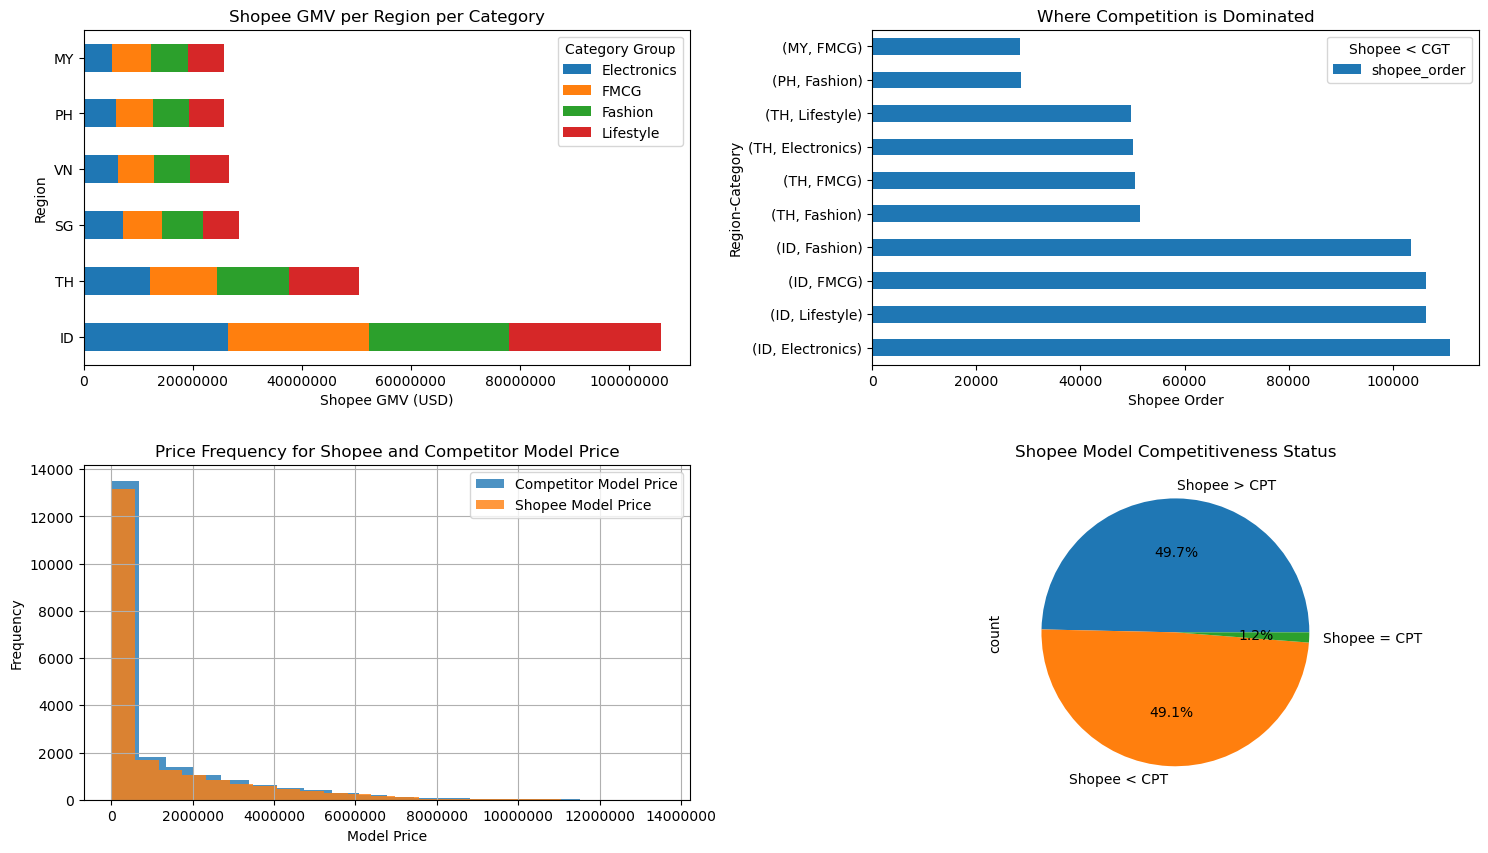

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

# Plot 1
axes[0, 0].set_title("Shopee GMV per Region per Category")
df_pricing.pivot_table(index="grass_region", columns="category_group", values="shopee_gmv_usd", aggfunc="sum").sort_values("Electronics", ascending=False).plot(kind="barh", stacked=True, ax=axes[0, 0]).ticklabel_format(axis="x", style="plain")
axes[0, 0].set_xlabel("Shopee GMV (USD)")
axes[0, 0].set_ylabel("Region")
axes[0, 0].legend(title="Category Group")

# Plot 2
axes[0, 1].set_title("Where Competition is Dominated")
df_pricing.loc[df_pricing["shopee_model_competitiveness_status"] == "Shopee < CPT", ["grass_region", "category_group", "shopee_model_competitiveness_status", "shopee_order"]].groupby(by=["grass_region", "category_group", "shopee_model_competitiveness_status"], as_index=False)[["shopee_order"]].sum().drop(columns="shopee_model_competitiveness_status").sort_values("shopee_order", ascending=False).head(10).set_index(["grass_region", "category_group"]).plot(kind="barh", ax=axes[0, 1])
axes[0, 1].set_xlabel("Shopee Order")
axes[0, 1].set_ylabel("Region-Category")
axes[0, 1].legend(title="Shopee < CGT")

# Plot 3
axes[1, 0].set_title("Price Frequency for Shopee and Competitor Model Price")
df_pricing["competitor_model_price"].hist(bins=20, alpha=0.8, label="Competitor Model Price", ax=axes[1, 0]).ticklabel_format(axis="x", style="plain")
df_pricing["shopee_model_price"].hist(bins=20, alpha=0.8, label="Shopee Model Price", ax=axes[1, 0]).ticklabel_format(axis="x", style="plain")
axes[1, 0].legend()
axes[1, 0].set_xlabel("Model Price")
axes[1, 0].set_ylabel("Frequency")

# Plot 4
axes[1, 1].set_title("Shopee Model Competitiveness Status")
df_pricing.value_counts("shopee_model_competitiveness_status").plot(kind="pie", autopct='%1.1f%%', ax=axes[1, 1])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()